## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.randn(3, 2)
y = torch.randn(3, 2)

In [3]:
x

tensor([[ 1.4788,  2.5016],
        [ 1.5650,  1.3157],
        [ 0.3031, -1.6828]])

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [4]:
z = torch.empty(3, 3)
z

tensor([[3.7378e-36, 0.0000e+00, 3.3631e-44],
        [0.0000e+00,        nan, 0.0000e+00],
        [1.1578e+27, 1.1362e+30, 7.1547e+22]])

In [5]:
torch.matmul(x, y.t(), out = z)
z

tensor([[-1.9858,  1.9882,  0.4190],
        [-0.9264,  1.1303, -0.2743],
        [ 1.5304, -1.1979, -1.0974]])

In [6]:
x @ y.t() #проверяю, что совпадает с выдачей

tensor([[-1.9858,  1.9882,  0.4190],
        [-0.9264,  1.1303, -0.2743],
        [ 1.5304, -1.1979, -1.0974]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [7]:
def relu_forward(x): #сделала таким образом, чтоб работать с любыим размерностями, не только двумерными
    z = x.reshape(-1) #аналог flatten только без flatten
    for i in range(z.shape[0]): 
        z[i] = max(0, z[i])
    z = z.reshape(x.shape) #делаем опять матричку исходного размера
    return z 

assert torch.all(F.relu(x) == relu_forward(x))

In [8]:
relu_forward(x)

tensor([[1.4788, 2.5016],
        [1.5650, 1.3157],
        [0.3031, 0.0000]])

In [9]:
F.relu(x) #тоже проверяю, что все сходится 

tensor([[1.4788, 2.5016],
        [1.5650, 1.3157],
        [0.3031, 0.0000]])

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [10]:
def elu_forward(x):
    z = x.reshape(-1) 
    for i in range(z.shape[0]): 
        z[i] = max(0, z[i]) + min(0, 1.0*(torch.exp(z[i]) - 1))  #я тут беру дефолтное значение альфа = 1, так как
        #в функции изначально но вход не поступает альфа, т.е ее нельзя задать 
    z = z.reshape(x.shape)
    return z 
    

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

In [11]:
F.elu(x)

tensor([[1.4788, 2.5016],
        [1.5650, 1.3157],
        [0.3031, 0.0000]])

In [12]:
elu_forward(x)

tensor([[1.4788, 2.5016],
        [1.5650, 1.3157],
        [0.3031, 0.0000]])

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [13]:
def lrelu_forward(x, alpha):
    z = x.reshape(-1) 
    for i in range(z.shape[0]):
        z[i] = max(0, z[i]) + alpha*min(0, z[i])
    z = z.reshape(x.shape)
    return z 

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

In [14]:
F.leaky_relu(x, 0.01)

tensor([[1.4788, 2.5016],
        [1.5650, 1.3157],
        [0.3031, 0.0000]])

In [15]:
lrelu_forward(x, 0.01)

tensor([[1.4788, 2.5016],
        [1.5650, 1.3157],
        [0.3031, 0.0000]])

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [16]:
def mish(x):
    def tanh(arg): 
        tanh = (torch.exp(arg) - torch.exp(-arg))/ (torch.exp(arg) + torch.exp(-arg))
        return tanh 
    
    z = x.reshape(-1) 
    for i in range(z.shape[0]):
        z[i] = z[i]*tanh(torch.log(1 + torch.exp(z[i])))
    z = z.reshape(x.shape)
    return z 

In [17]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

In [18]:
mish(torch.tensor([1, 1, 1], dtype=torch.float32))

tensor([0.8651, 0.8651, 0.8651])

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [19]:
def swish(x):
    z = x.reshape(-1) 
    for i in range(z.shape[0]):
        z[i] = z[i]*(1 / (1 + torch.exp(-z[i]))) 
    z = z.reshape(x.shape)
    return z 

In [20]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

In [21]:
swish(torch.tensor([1, 1, 1], dtype=torch.float32))

tensor([0.7311, 0.7311, 0.7311])

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [22]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [23]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']

        for param in filter(lambda x: x.grad is not None, group['params']):
            #print("param before", param) 
            #print(group['params'])
            self._init_adam_buffer(param) #инициализируем веса, если еще не заданы
            param_state = self.state[param]
            v, m, step = self._get_adam_buffer(param) #достаем бафферы для параметра из словаря
            #print(param_state)
            d_param = param.grad #считаем градиент
            m.data = beta_1*m + (1 - beta_1)*d_param 
            v.data = beta_2*v + (1 - beta_2)*(d_param**2)
            m_hat = m /(1 - (beta_1 ** step))
            v_hat = v / (1 - (beta_2 ** step)) 
            param.data = param - ((lr*m_hat)/(torch.sqrt(v_hat + eps))) #обновляем веса 
            
            param_state['step'] += 1 #обновляем шаг 
            #print("param after", param, step) 
            
            
    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['v'], param_state['m'], param_state['step']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'm' not in param_state:
            param_state['m'] = torch.zeros_like(param) 
        if 'v' not in param_state:
            param_state['v'] = torch.zeros_like(param)
        if "step" not in param_state: 
            param_state["step"] = 1 
            

In [24]:
def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f'Iteration {i} loss:', output.item())

In [25]:
from sklearn.datasets import make_regression
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)

def get_model():
    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1))

In [26]:
def get_model():
    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1))

In [27]:
model = get_model()
optim = Adam(model.parameters())
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 6677.54296875
Iteration 100 loss: 6570.23388671875
Iteration 200 loss: 6391.275390625
Iteration 300 loss: 6112.265625
Iteration 400 loss: 5733.1123046875
Iteration 500 loss: 5268.005859375
Iteration 600 loss: 4739.1142578125
Iteration 700 loss: 4171.005859375
Iteration 800 loss: 3588.583740234375
Iteration 900 loss: 3014.745849609375


In [28]:
model = get_model() #Проверяю, что выдача одинаковая 
optim = torch.optim.Adam(model.parameters())
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 6677.54296875
Iteration 100 loss: 6570.23388671875
Iteration 200 loss: 6391.275390625
Iteration 300 loss: 6112.265625
Iteration 400 loss: 5733.1123046875
Iteration 500 loss: 5268.005859375
Iteration 600 loss: 4739.1142578125
Iteration 700 loss: 4171.005859375
Iteration 800 loss: 3588.583984375
Iteration 900 loss: 3014.746337890625


**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [29]:
n_in = 784 #784 пикселя на вход
n_out = 10 #всего 10 классов одежды 

low = -(6**0.5)/(n_in + n_out)**0.5
high = (6**0.5)/(n_in + n_out)**0.5
print(low, high)

-0.08692913816996169 0.08692913816996169


In [30]:
np.random.seed(0)

weights = torch.tensor(np.random.uniform(low, high, size=(10,784)), dtype=torch.float32, requires_grad = True)
bias = torch.tensor(np.random.uniform(low, high, size= 10), dtype=torch.float32, requires_grad = True)

In [31]:
bias

tensor([-0.0017, -0.0687, -0.0604,  0.0155, -0.0181, -0.0133,  0.0014,  0.0279,
        -0.0001, -0.0275], requires_grad=True)

Загрузим данные и создадим даталоадеры:

In [32]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [33]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader =  DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=2
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=128, num_workers=2
)

Напишите функцию для тренировки логистической регрессии, она должна:  \\

    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики


    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [34]:
import tqdm.notebook as tq

In [35]:
criterion = torch.nn.CrossEntropyLoss()

In [36]:
model = nn.Linear(784, 10, bias = True) #тут я задаю модель
list(model.parameters())

[Parameter containing:
 tensor([[-0.0318,  0.0202, -0.0063,  ..., -0.0175, -0.0175,  0.0130],
         [ 0.0348,  0.0075, -0.0065,  ..., -0.0297, -0.0210,  0.0001],
         [ 0.0338,  0.0091, -0.0202,  ..., -0.0005,  0.0141, -0.0220],
         ...,
         [-0.0199, -0.0007,  0.0099,  ..., -0.0168,  0.0316,  0.0349],
         [-0.0102,  0.0223, -0.0236,  ...,  0.0159, -0.0203, -0.0315],
         [-0.0140, -0.0244,  0.0175,  ..., -0.0107,  0.0329,  0.0346]],
        requires_grad=True), Parameter containing:
 tensor([-0.0139, -0.0183,  0.0169, -0.0266, -0.0219,  0.0313, -0.0076, -0.0020,
         -0.0140,  0.0327], requires_grad=True)]

In [37]:
weights = nn.Parameter(weights) #вручную делаю Xavier инициализацию, с помощью весов, которые были заданы выше 
model.weight = weights
bias = nn.Parameter(bias) 
model.bias = bias 

In [38]:
bias

Parameter containing:
tensor([-0.0017, -0.0687, -0.0604,  0.0155, -0.0181, -0.0133,  0.0014,  0.0279,
        -0.0001, -0.0275], requires_grad=True)

In [39]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0085,  0.0374,  0.0179,  ..., -0.0127,  0.0596,  0.0553],
         [-0.0691, -0.0597, -0.0340,  ..., -0.0278, -0.0750, -0.0471],
         [-0.0247, -0.0113,  0.0158,  ..., -0.0868, -0.0748, -0.0476],
         ...,
         [-0.0216, -0.0782,  0.0508,  ...,  0.0531,  0.0505,  0.0670],
         [-0.0781,  0.0838, -0.0128,  ..., -0.0214, -0.0839, -0.0436],
         [ 0.0263, -0.0655,  0.0281,  ..., -0.0274,  0.0694, -0.0610]],
        requires_grad=True), Parameter containing:
 tensor([-0.0017, -0.0687, -0.0604,  0.0155, -0.0181, -0.0133,  0.0014,  0.0279,
         -0.0001, -0.0275], requires_grad=True)]

In [40]:
def train_logistic_regression(model, criterion, optimizer, train_dataloader, test_dataloader):
    
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    train_epoch_loss = []
    train_epoch_acc = []

    for epoch in tq.tqdm(range(100)):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
      
        for batch in train_dataloader:
            
            optimizer.zero_grad()
            imgs, labels = batch
            imgs = imgs.reshape(-1, 784) #вытягиваем квартинки из двумерных матриц в один длинный тензор с пикселями
            y_pred = torch.softmax(model(imgs), dim = -1) #делаем предсказания и переводим их в вероятности
            loss = criterion(y_pred, labels) #считаем лосс
           
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data) #запоминаем лосс на этом батче 
            
            loss.backward()
            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item() #считаем число верных ответов
            train_acc_log.append(torch.sum(pred_classes == labels).item() / len(pred_classes)) #запоминаем accuracy на этом батче
             
            optimizer.step() #обновляем веса
            
        
        
        model.eval() 
        val_loss = []
        val_acc = [] 
        with torch.no_grad(): 
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.reshape(-1, 784)
                pred = torch.softmax(model(imgs), dim = -1) 
                loss = criterion(pred, labels)
                val_loss.append(loss.item())
                _, pred_classes = torch.max(pred, 1)
                val_acc.append((pred_classes == labels).sum().item() / len(pred_classes))
        val_loss_log.append(np.mean(val_loss)) #для тестовой выборки и запоминаю метрики по эпохам, а не по итерациям
        val_acc_log.append(np.mean(val_acc)) #для этого берем среднее от всех метрик на батче, а потом на новой эпохе перезадем словари val_loaa & val_acc
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


In [41]:
optimizer = torch.optim.Adam(model.parameters())
metrics = train_logistic_regression(model, criterion, optimizer, train_dataloader, eval_dataloader)

In [42]:
loss_train, accuracy_train, loss_test, acc_test = metrics 

In [43]:
def plot_history(train_history, val_history, title, size):
    plt.figure(figsize=size) #здесь я сделала побольше размер картинок, так как очень много эпох 
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

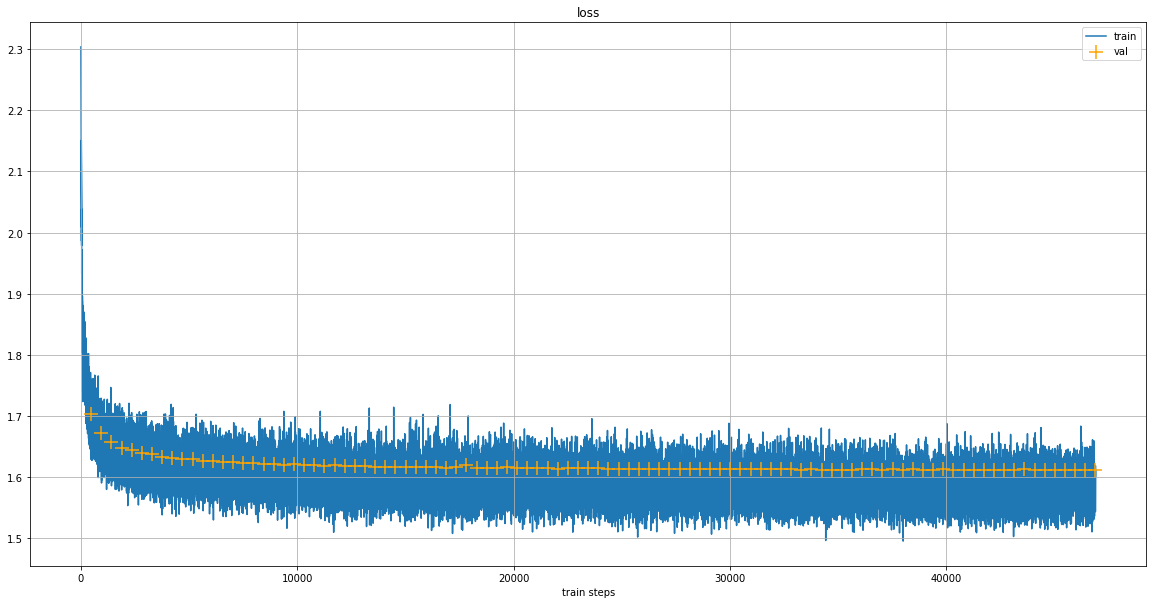

In [44]:
plot_history(loss_train, loss_test, "loss", (20,10))

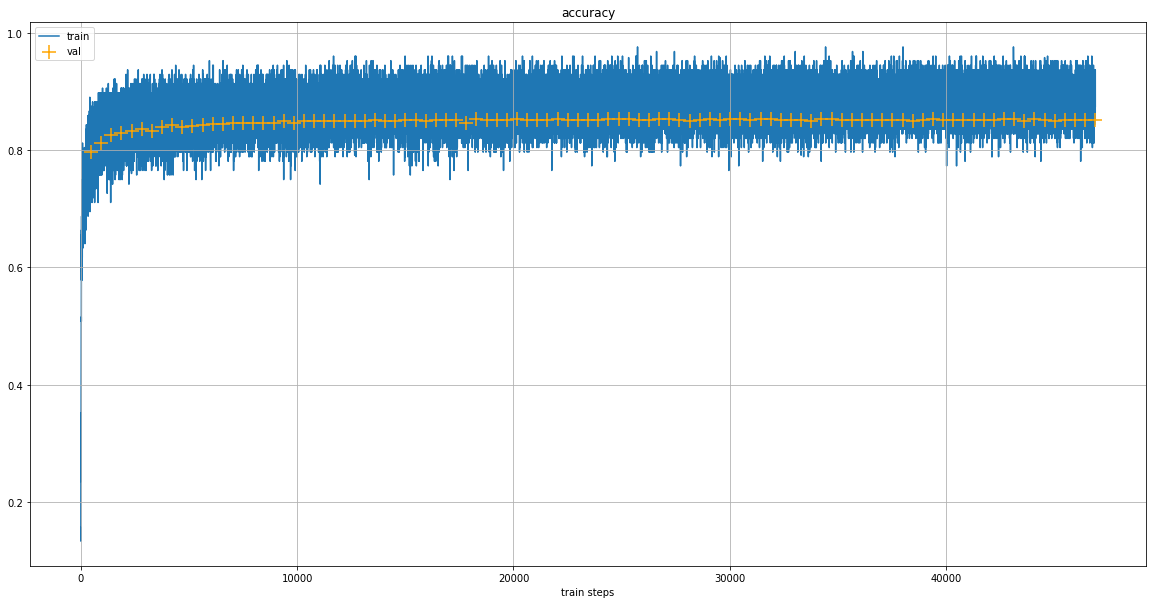

In [45]:
plot_history(accuracy_train, acc_test, "accuracy", (20, 10))

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

1) По сути это обеспечивается за счет деления элемента v (который накапливает квадраты градиентов) на (1 - бета2^t). Для того, чтоб оценка была несмещенной, нам необходимо, чтобы математическое ожидание оценки было равно математическому ожиданию квадрата градиента. Если мы распишем математическое ожидание от v, оно будет равняться математическому ожиданию квадрата градиента * (1 - бета2) * сумма бета2t.  Последние два элемента по сути представлюят собой геометрическую прогрессию, которую можно выразить как раз через 1 - бета2t. Соответственно, матожидание v = матожидание квадрата градиентов * (1 - бета2t). Тогда нам остается только разделить v на этот элемент, чтоб получит несмещенную оценку, тогда матожидания сравняются (в формуле, которая нам дана выше – математическое ожидание v_hat будет равно математическому ожиданию квадрата градиентов). Тогда при этом делении мы и можем получить несмещенные оценки на квадрат градиента. Извините если много математики, хз как по-другому объяснить... 

2) 

Как мы видим, самое большое значение accuracy на тестировании получается не на последней эпохе обучения. То есть после определенного шага модель скорее всего начала переобучаться, и качество на тесте начало понижаться. Качество не то чтобы сильно падает к концу обучения, но значения начинают скакать в небольшом диапазоне. С этого момента модель больше "не улучшается". Скорее всего, если бы мы добавили еще несколько эпох (условно, 150), качество бы уже начало существенно падать. Также видно, что лосс со временем перестает значимым образом убывать. После этого он колеблется около какой-то константы, заметно, что он даже немного наинчает расти на последних значениях. В общем и целом, лосс и accuracy сначала изменяются значимым образом и модель обучается, а дальше они почти не сдвигаются. Тогда модель модель начинает просто подгоняться под данные, веса уже не меняются существенным образом. С течением времени мы бы заметили, что модель скорее запоминает тренировочную выборку, нежели учится делать хорошие предсказания. 

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [49]:
def train_model(model, num_epochs, train_dataloader, test_dataloader, optimizer):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []


    for epoch in tq.tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0
      
        for batch in train_dataloader:
        
            imgs, labels = batch
            optimizer.zero_grad() #зануляем градиенты
            y_pred = model(imgs) #делаем предсказания и переводим их в вероятности
            loss = criterion(y_pred, labels) #считаем лосс
           
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data) #запоминаем лосс на этом батче 
            
            loss.backward()
            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()   #тут я запоминаю accuracy на батчах, чтоб потом вывести показатель по эпохе
            train_acc_log.append(torch.sum(pred_classes == labels).item() / len(pred_classes)) #тут записываются все accuracy вообще
             
            optimizer.step() #обновляем веса
            
        
        
        model.eval() 
        val_loss = []
        val_acc = [] 
        with torch.no_grad(): 
            for batch in test_dataloader:
                imgs, labels = batch
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss.append(loss.item())
                _, pred_classes = torch.max(pred, 1)
                val_acc.append((pred_classes == labels).sum().item() / len(pred_classes))
        val_loss_log.append(np.mean(val_loss)) #для тестовой выборки и запоминаю метрики по эпохам, а не по итерациям
        val_acc_log.append(np.mean(val_acc)) #для этого берем среднее от всех метрик на батче, а потом на новой эпохе перезадем словари val_loaa & val_acc

        print(f"Epoch: {epoch}, Train Loss: {train_loss/len(train_dataloader)}, Train Accuracy: {train_acc/train_size}, Test Loss: {val_loss_log[epoch]}, Test Accuracy: {val_acc_log[epoch]}  ")
    #строка выше выводит средние по эпохам для трейна и теста 
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


In [50]:
class FirstModel(nn.Module): #это будет простая полносвязная сеточка 
    def __init__(self):
        super(FirstModel, self).__init__()
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.ReLu = nn.ReLU()
        self.probs = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.Flatten(x)
        x = self.fc1(x)
        x = self.ReLu(x)
        x = self.fc2(x)
        x = self.ReLu(x)
        x = self.fc3(x)
        x = self.probs(x)

        return x

First_model = FirstModel()

In [51]:
first_SGD = train_model(
    model=First_model,
    num_epochs=40, #я сделала число эпох побольше, потому что часто модель недообучалась 
    train_dataloader=train_dataloader,
    test_dataloader=eval_dataloader,
    optimizer=torch.optim.SGD(First_model.parameters(), lr=0.01)) #LR увеличила, так как иначе очень долго сходилось 

Epoch: 0, Train Loss: 2.300689087747765, Train Accuracy: 0.11346666666666666, Test Loss: 2.298082077050511, Test Accuracy: 0.16693037974683544  
Epoch: 1, Train Loss: 2.2944018296849755, Train Accuracy: 0.2201, Test Loss: 2.2902263840542565, Test Accuracy: 0.2587025316455696  
Epoch: 2, Train Loss: 2.2838390397110473, Train Accuracy: 0.2977666666666667, Test Loss: 2.275955764553215, Test Accuracy: 0.3471123417721519  
Epoch: 3, Train Loss: 2.262460821473014, Train Accuracy: 0.32675, Test Loss: 2.2446719996536832, Test Accuracy: 0.30666534810126583  
Epoch: 4, Train Loss: 2.210814701214528, Train Accuracy: 0.29735, Test Loss: 2.168885252143763, Test Accuracy: 0.33989319620253167  
Epoch: 5, Train Loss: 2.1274321114839014, Train Accuracy: 0.35781666666666667, Test Loss: 2.091697750212271, Test Accuracy: 0.3692642405063291  
Epoch: 6, Train Loss: 2.054805165414871, Train Accuracy: 0.4433, Test Loss: 2.018173969244655, Test Accuracy: 0.49861550632911394  
Epoch: 7, Train Loss: 1.9723071909

In [52]:
FMtrain_loss, FMtrain_acc, FMval_loss, FMval_acc = first_SGD

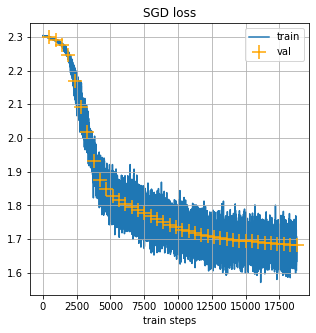

In [53]:
plot_history(FMtrain_loss, FMval_loss, "SGD loss", (5, 5))

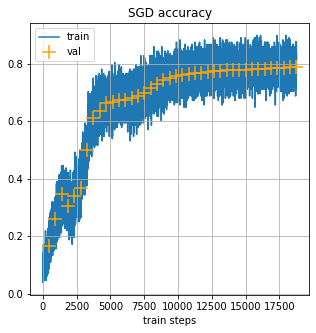

In [54]:
plot_history(FMtrain_acc, FMval_acc, "SGD accuracy", (5, 5))

In [55]:
class FirstModel(nn.Module): #снова инициализирую модель, чтобы начать обучение заново (иначе он часто начинает дообучивать то, что уже обучено, так что я на всякий задаю класс опять)
    def __init__(self):
        super(FirstModel, self).__init__()
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.ReLu = nn.ReLU()
        self.probs = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.Flatten(x)
        x = self.fc1(x)
        x = self.ReLu(x)
        x = self.fc2(x)
        x = self.ReLu(x)
        x = self.fc3(x)
        x = self.probs(x)

        return x

First_model = FirstModel() 

In [56]:
first_RMS = train_model(
    model=First_model,
    num_epochs=15, #меньше число эпох, так как обучается он очень быстро 
    train_dataloader=train_dataloader,
    test_dataloader=eval_dataloader,
    optimizer = torch.optim.RMSprop(First_model.parameters(), lr = 0.0001, alpha=0.99)) #сделала поменьше lr на всякий случай, чтоб не переобучиться  

Epoch: 0, Train Loss: 1.9071008279633674, Train Accuracy: 0.5997, Test Loss: 1.8225831789306448, Test Accuracy: 0.6556566455696202  
Epoch: 1, Train Loss: 1.7790320938838315, Train Accuracy: 0.7120333333333333, Test Loss: 1.7527010350287715, Test Accuracy: 0.7352650316455697  
Epoch: 2, Train Loss: 1.7322714298264559, Train Accuracy: 0.7516666666666667, Test Loss: 1.726203969762295, Test Accuracy: 0.7508900316455697  
Epoch: 3, Train Loss: 1.7131513148736852, Train Accuracy: 0.7631666666666667, Test Loss: 1.7146078710314594, Test Accuracy: 0.7578125  
Epoch: 4, Train Loss: 1.7018677537629345, Train Accuracy: 0.7701833333333333, Test Loss: 1.7043780737285372, Test Accuracy: 0.7654272151898734  
Epoch: 5, Train Loss: 1.6937363620505912, Train Accuracy: 0.7775333333333333, Test Loss: 1.699662623526175, Test Accuracy: 0.7702729430379747  
Epoch: 6, Train Loss: 1.688001944057977, Train Accuracy: 0.7814166666666666, Test Loss: 1.6927832787549948, Test Accuracy: 0.775118670886076  
Epoch: 7, 

In [57]:
RMSFMtrain_loss, RMSFMtrain_acc, RMSFMval_loss, RMSFMval_acc = first_RMS

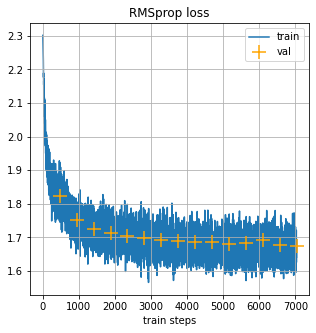

In [58]:
plot_history(RMSFMtrain_loss, RMSFMval_loss, "RMSprop loss", (5, 5))

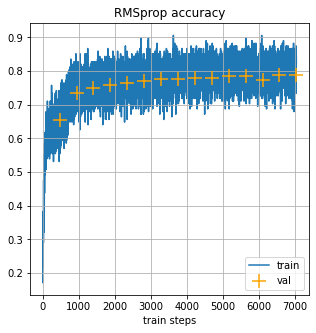

In [59]:
plot_history(RMSFMtrain_acc, RMSFMval_acc, "RMSprop accuracy", (5, 5))

In [60]:
second_model = nn.Sequential(
    nn.Conv2d(1, 6, 3, padding = 1), #входной канал равен 1, так как у нас картинка черно-белая
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(6, 16, 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(), 
    nn.Linear(128, 10),
    nn.Softmax(dim=-1) 
  
    
) #это что-то вроде VGG-модели – здесь я беру очень мелкие свертки, вставляю их между пулингами 

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
second_model.to(device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=784, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
  (10): Softmax(dim=-1)
)

In [63]:
for i in train_dataloader: 
  break 

In [64]:
i[0].shape

torch.Size([128, 1, 28, 28])

In [65]:
a = second_model(i[0].to(device)) #код для проверки сколько нейронов поступит на выход flatten
a.shape

torch.Size([128, 10])

In [66]:
second_SGD = train_model(
    model= second_model,
    num_epochs=15, #поменьше эпох, потому что переобучается 
    train_dataloader=train_dataloader,
    test_dataloader=eval_dataloader,
    optimizer=torch.optim.SGD(second_model.parameters(), lr=0.01))

Epoch: 0, Train Loss: 2.3024247150177133, Train Accuracy: 0.07965, Test Loss: 2.3018215939968445, Test Accuracy: 0.1115506329113924  
Epoch: 1, Train Loss: 2.3012845841552148, Train Accuracy: 0.11911666666666666, Test Loss: 2.300753756414486, Test Accuracy: 0.12480221518987342  
Epoch: 2, Train Loss: 2.3000318571956937, Train Accuracy: 0.14478333333333335, Test Loss: 2.299231037308898, Test Accuracy: 0.15634889240506328  
Epoch: 3, Train Loss: 2.2978881910157356, Train Accuracy: 0.15525, Test Loss: 2.296245843549318, Test Accuracy: 0.18097310126582278  
Epoch: 4, Train Loss: 2.293085263482035, Train Accuracy: 0.20225, Test Loss: 2.2886396329614183, Test Accuracy: 0.236748417721519  
Epoch: 5, Train Loss: 2.2737988419115926, Train Accuracy: 0.32766666666666666, Test Loss: 2.237248191350623, Test Accuracy: 0.4140625  
Epoch: 6, Train Loss: 2.088736160223418, Train Accuracy: 0.45615, Test Loss: 1.9704343110700198, Test Accuracy: 0.542128164556962  
Epoch: 7, Train Loss: 1.936108965355196,

In [67]:
SMtrain_loss, SMtrain_acc, SMval_loss, SMval_acc = second_SGD

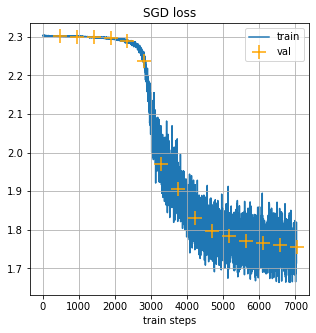

In [68]:
plot_history(SMtrain_loss, SMval_loss, "SGD loss", (5, 5))

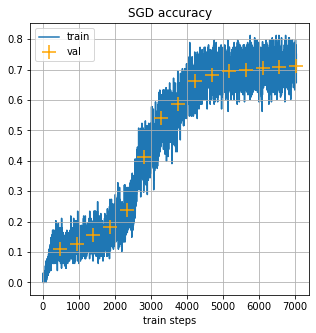

In [69]:
plot_history(SMtrain_acc, SMval_acc, "SGD accuracy", (5, 5))

In [70]:
second_model = nn.Sequential(
    nn.Conv2d(1, 6, 3, padding = 1), #тоже на всякий случай пересоздаю модель, чтобы не продолжить обучать старую
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(6, 16, 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(), 
    nn.Linear(128, 10),
    nn.Softmax(dim=-1) 
  
    
) 

In [71]:
second_RMS = train_model(
    model=second_model,
    num_epochs=15, #меньше число эпох, так как обучается он очень быстро 
    train_dataloader=train_dataloader,
    test_dataloader=eval_dataloader,
    optimizer = torch.optim.RMSprop(second_model.parameters(), lr = 0.001, alpha=0.99)) #сделала поменьше lr на всякий случай, чтоб не переобучиться 

Epoch: 0, Train Loss: 1.7963648043207523, Train Accuracy: 0.6680333333333334, Test Loss: 1.7595355993584743, Test Accuracy: 0.7009493670886076  
Epoch: 1, Train Loss: 1.6906337277975672, Train Accuracy: 0.7717, Test Loss: 1.6488421808315228, Test Accuracy: 0.8153678797468354  
Epoch: 2, Train Loss: 1.6408798526853388, Train Accuracy: 0.8217333333333333, Test Loss: 1.6420185611217837, Test Accuracy: 0.8216969936708861  
Epoch: 3, Train Loss: 1.6182400852378243, Train Accuracy: 0.84435, Test Loss: 1.617335557937622, Test Accuracy: 0.8457278481012658  
Epoch: 4, Train Loss: 1.5972069283284105, Train Accuracy: 0.8661833333333333, Test Loss: 1.5963311135014402, Test Accuracy: 0.8662974683544303  
Epoch: 5, Train Loss: 1.5908236074040947, Train Accuracy: 0.8710833333333333, Test Loss: 1.593162874632244, Test Accuracy: 0.8691653481012658  
Epoch: 6, Train Loss: 1.58462625805503, Train Accuracy: 0.87755, Test Loss: 1.587834444227098, Test Accuracy: 0.8752966772151899  
Epoch: 7, Train Loss: 1.

In [72]:
RMSSMtrain_loss, RMSSMtrain_acc, RMSSMval_loss, RMSSMval_acc = second_RMS

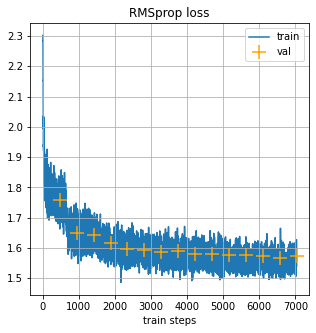

In [73]:
plot_history(RMSSMtrain_loss, RMSSMval_loss, "RMSprop loss", (5, 5))

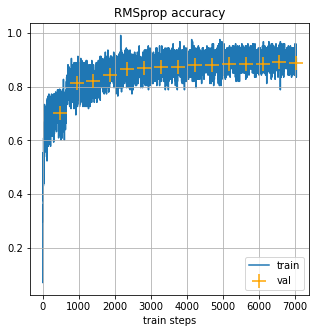

In [74]:
plot_history(RMSSMtrain_acc, RMSSMval_acc, "RMSprop accuracy", (5, 5))

In [75]:
third_model = nn.Sequential( #для третьей модели я хочу взять большие свертки, но применирь еще Dropout и Batchnorm 
    nn.Conv2d(1, 16, (9, 9), stride = 2),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(16, 8, (5, 5), padding = 1),
    nn.BatchNorm2d(8), 
    nn.Flatten(), 
    nn.Linear(72, 32), 
    nn.Dropout(p=0.4), 
    nn.ReLU(), 
    nn.Linear(32, 10), 
    nn.Softmax(dim =-1))
     
    

In [76]:
third_model.to(device)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(2, 2))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Flatten()
  (5): Linear(in_features=72, out_features=32, bias=True)
  (6): Dropout(p=0.4, inplace=False)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=10, bias=True)
  (9): Softmax(dim=-1)
)

In [77]:
b = third_model(i[0].to(device)) #код для проверки сколько нейронов поступит на выход flatten
b.shape

torch.Size([128, 10])

In [78]:
third_SGD = train_model(
    model= third_model,
    num_epochs=15, #поменьше эпох, потому что переобучается 
    train_dataloader=train_dataloader,
    test_dataloader=eval_dataloader,
    optimizer=torch.optim.SGD(third_model.parameters(), lr=0.01))

Epoch: 0, Train Loss: 2.2208978402843353, Train Accuracy: 0.32555, Test Loss: 2.1180678168429603, Test Accuracy: 0.5220530063291139  
Epoch: 1, Train Loss: 2.057159726553634, Train Accuracy: 0.5180666666666667, Test Loss: 1.9544822415219079, Test Accuracy: 0.5755537974683544  
Epoch: 2, Train Loss: 1.9490398321070397, Train Accuracy: 0.5762833333333334, Test Loss: 1.884555913225005, Test Accuracy: 0.6128362341772152  
Epoch: 3, Train Loss: 1.8984514561289154, Train Accuracy: 0.6030833333333333, Test Loss: 1.848265883288806, Test Accuracy: 0.6314280063291139  
Epoch: 4, Train Loss: 1.8669870878333477, Train Accuracy: 0.6274333333333333, Test Loss: 1.8145263210127625, Test Accuracy: 0.6825553797468354  
Epoch: 5, Train Loss: 1.8281448372899851, Train Accuracy: 0.6757, Test Loss: 1.7669760335849811, Test Accuracy: 0.7193433544303798  
Epoch: 6, Train Loss: 1.7999173636629637, Train Accuracy: 0.6950166666666666, Test Loss: 1.7495601131946226, Test Accuracy: 0.7285403481012658  
Epoch: 7, T

In [79]:
TMtrain_loss, TMtrain_acc, TMval_loss, TMval_acc = third_SGD

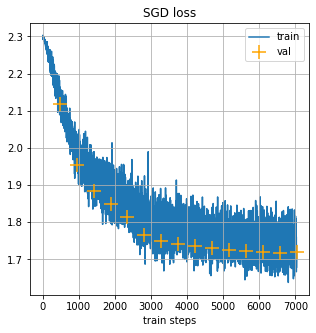

In [80]:
plot_history(TMtrain_loss, TMval_loss, "SGD loss", (5, 5))

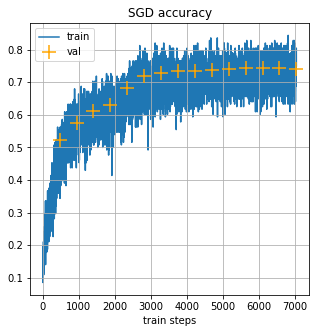

In [81]:
plot_history(TMtrain_acc, TMval_acc, "SGD accuracy", (5, 5))

In [82]:
third_RMS = train_model(
    model=third_model,
    num_epochs=15, 
    train_dataloader=train_dataloader,
    test_dataloader=eval_dataloader,
    optimizer = torch.optim.RMSprop(third_model.parameters(), lr = 0.001, alpha=0.99))

Epoch: 0, Train Loss: 1.704631302910827, Train Accuracy: 0.7663833333333333, Test Loss: 1.6330327414259125, Test Accuracy: 0.8338607594936709  
Epoch: 1, Train Loss: 1.652792189929531, Train Accuracy: 0.8142666666666667, Test Loss: 1.6438648444187791, Test Accuracy: 0.8188291139240507  
Epoch: 2, Train Loss: 1.6408284305255296, Train Accuracy: 0.8247, Test Loss: 1.6426150512091722, Test Accuracy: 0.8193235759493671  
Epoch: 3, Train Loss: 1.6332071211292292, Train Accuracy: 0.8319166666666666, Test Loss: 1.6123213390760784, Test Accuracy: 0.8504746835443038  
Epoch: 4, Train Loss: 1.6281986826264274, Train Accuracy: 0.8371666666666666, Test Loss: 1.6080105410346501, Test Accuracy: 0.8537381329113924  
Epoch: 5, Train Loss: 1.6242969605460096, Train Accuracy: 0.8398166666666667, Test Loss: 1.6093784133090248, Test Accuracy: 0.8514636075949367  
Epoch: 6, Train Loss: 1.6192572035514978, Train Accuracy: 0.84415, Test Loss: 1.6032209336003171, Test Accuracy: 0.8572982594936709  
Epoch: 8, 

In [83]:
RMSTMtrain_loss, RMSTMtrain_acc, RMSTMval_loss, RMSTMval_acc = third_RMS

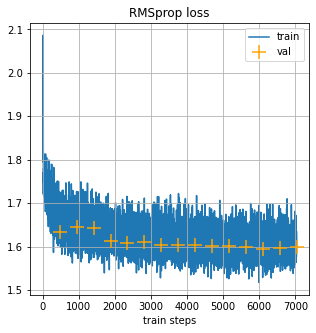

In [84]:
plot_history(RMSTMtrain_loss, RMSTMval_loss, "RMSprop loss", (5, 5))

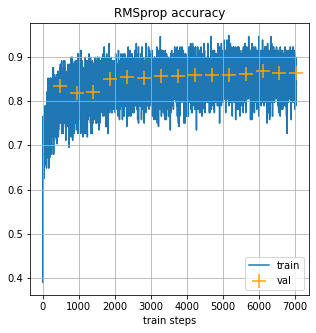

In [85]:
plot_history(RMSTMtrain_acc, RMSTMval_acc, "RMSprop accuracy", (5, 5))

Так как на всех моделях RMSprop выдавал более выскоие значения accuracy, сравнивать я буду именно по этому параметру. Также замечу, что RMSprop ожиаемо гораздо быстрее "спускался" до оптимальных параметров, и был гораздо менее подвержен разного рода сдвигам. Например, в первой модели видно, как на нескольких эпохах SGD как будто проседает, а RMS гораздо в меньшей степени отклоняется с пути, который уже был пройден при градиентном спуске, если он вообще отклоняется. Нужно еще указать, что я меняла некоторые параметры моделей, чтобы они подогнались лучшим образом (например, меняя число эпох или размер learning rate), так что они изначально обучались в разных условиях, чтобы добиться лучшего перфоманса. 

Самый высокий результат получился на второй модели (VGG-подобной), accuracy составила примерно 0.89. Это можно объяснить тем, что VGG более адекватна сложности данных, по сравнению с полносвязной моделью. Полностью полносвязная модель просто не может их достаточно хорошо смоделировать, так как сразу получает на вход вектор из пикселей, из-за чего она гораздо хуже выявляет какие-либо паттерны. Также преимуществом VGG на этих данных может быть небольшой размер сверток – сами по себе нам даны небольшие картинки, для определения класса, как мне кажется, нужно уловить сравнительно небольшие паттерны, вроде например изгиба плеч на верхней одежде или подошвы у обуви. Возможно, из-за этого последняя модель, – где использовались наоборот большие свертки, – не дала особенных преимуществ. Здесь скорее нужно было искать не большие патттерны, а более мелкие. Например, чтобы отличать свитер от рубашки, модели нужно не увидеть силуэт в целом (они будут примерно схожи у рубашки и свитера), а искать отличия в деталях. Однако примечательно, что последней модели с большими свертками и применением Batchnorm и Dropout (моя пародия на AlexNet...) не помогли последние два механизма, хотя тот же Batchnorm является довольно эффективным приемом. 